In [1]:
from __future__ import absolute_import
from __future__ import print_function
from future.standard_library import install_aliases
install_aliases()
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

In [2]:
def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)

In [3]:
def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images[:1000], test_labels[:1000]

In [4]:
def load_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

In [5]:
def plot_images(images, ax, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=None, vmax=None):
    """Images should be a (N_images x pixels) matrix."""
    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = np.min(images.ravel())
    concat_images = np.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    return cax

In [6]:
def save_images(images, filename, **kwargs):
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)
    plot_images(images, ax, **kwargs)
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)
    plt.savefig(filename)

In [7]:
def train_mle_estimator(train_images, train_labels):
    """ Inputs: train_images, train_labels
        Returns the MLE estimators theta_mle and pi_mle"""

    # YOU NEED TO WRITE THIS PART
    sample_per_class = np.sum(train_labels, axis=0)
    pi_mle = sample_per_class / float(train_labels.shape[0])
    
    theta_mle = train_images.transpose() @ train_labels
    
    theta_mle /= sample_per_class
    return theta_mle, pi_mle

In [8]:
def train_map_estimator(train_images, train_labels):
    """ Inputs: train_images, train_labels
        Returns the MAP estimators theta_map and pi_map"""
    
    # YOU NEED TO WRITE THIS PART
    sample_per_class = np.sum(train_labels, axis=0)
    pi_mle = sample_per_class / float(train_labels.shape[0])
    
    sample_per_class += 4
    theta_mle = train_images.transpose() @ train_labels + 2
    theta_mle /= sample_per_class
    
    return theta_mle, pi_mle

In [9]:
def log_likelihood(images, theta, pi):
    """ Inputs: images, theta, pi
        Returns the matrix 'log_like' of loglikehoods over the input images where
    log_like[i,c] = log p (c |x^(i), theta, pi) using the estimators theta and pi.
    log_like is a matrix of num of images x num of classes
    Note that log likelihood is not only for c^(i), it is for all possible c's."""

    # YOU NEED TO WRITE THIS PART
    ce = (images @ np.log(theta)) + ((1 - images) @ np.log(1 - theta)) + np.log(pi)
    pd = np.zeros(shape=(images.shape[0], 1))
    
    for i in range(images.shape[0]):
        x = images[i].reshape((images.shape[1],1))
        pd[i] = np.sum(np.prod(theta * x + (1 - theta) * (1 - x), axis=0) * pi)
    
    return ce - np.log(pd)

In [10]:
def predict(log_like):
    """ Inputs: matrix of log likelihoods
    Returns the predictions based on log likelihood values"""
    predictions = (log_like == np.max(log_like, axis=1, keepdims=1)).astype(int)
    # YOU NEED TO WRITE THIS PART
    return predictions

In [11]:
def accuracy(log_like, labels):
    """ Inputs: matrix of log likelihoods and 1-of-K labels
    Returns the accuracy based on predictions from log likelihood values"""
    pred = predict(log_like)
    accuracy = np.sum(np.all(pred == labels, axis=1)) / labels.shape[0]
    # YOU NEED TO WRITE THIS PART
    return accuracy

In [12]:
def image_sampler(theta, pi, num_images):
    """ Inputs: parameters theta and pi, and number of images to sample
    Returns the sampled images"""
    labels = np.random.choice(a=len(pi),size=num_images,p=pi)
    probs = theta[:,labels].transpose()
    sampled_images = np.random.binomial(1, probs)
    # YOU NEED TO WRITE THIS PART
    return sampled_images

### Train with naive bayes model

In [13]:
N_data, train_images, train_labels, test_images, test_labels = load_mnist()
# Fit MLE and MAP estimators
theta_mle, pi_mle = train_mle_estimator(train_images, train_labels)
theta_map, pi_map = train_map_estimator(train_images, train_labels)

# Find the log likelihood of each data point
loglike_train_mle = log_likelihood(train_images, theta_mle, pi_mle)
loglike_train_map = log_likelihood(train_images, theta_map, pi_map)

avg_loglike_mle = np.sum(loglike_train_mle * train_labels) / N_data
avg_loglike_map = np.sum(loglike_train_map * train_labels) / N_data

print("Average log-likelihood for MLE is ", avg_loglike_mle)
print("Average log-likelihood for MAP is ", avg_loglike_map)

train_accuracy_map = accuracy(loglike_train_map, train_labels)
loglike_test_map = log_likelihood(test_images, theta_map, pi_map)
test_accuracy_map = accuracy(loglike_test_map, test_labels)

print("Training accuracy for MAP is ", train_accuracy_map)
print("Test accuracy for MAP is ", test_accuracy_map)

/home/lichiheng/.conda/envs/csc311env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/lichiheng/.conda/envs/csc311env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':


Average log-likelihood for MLE is  nan
Average log-likelihood for MAP is  -3.357063137860309
Training accuracy for MAP is  0.8352166666666667
Test accuracy for MAP is  0.816


### Plot mle and map estimators

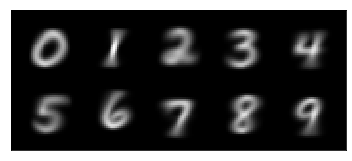

In [14]:
# Plot MLE estimators
save_images(theta_mle.T, 'mle.png', cmap='gray')

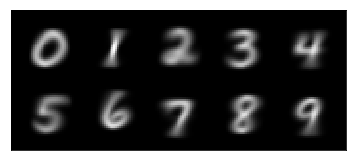

In [15]:
# Plot MAP estimators
save_images(theta_map.T, 'map.png', cmap='gray')

### Generate samples from the generative model

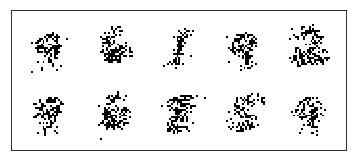

In [16]:
# Sample 10 images
sampled_images = image_sampler(theta_map, pi_map, 10)
save_images(sampled_images, 'sampled_images.png')